# Trading MVP – Should We Trade Tomorrow?

This notebook contains a complete, **reproducible** pipeline:
1. Data audit and cleansing
2. Feature engineering (rolling behaviour metrics)
3. Label creation (predict next‑day bad trading day)
4. Expanding‑window time‑series split
5. Baseline, logistic‑regression, and LightGBM models
6. Evaluation metrics & monetary lift
7. Risk‑management dashboard plots

Adjust paths and parameters in the first code cell as needed.

In [20]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, joblib, lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    confusion_matrix,
)
from sklearn.model_selection import TimeSeriesSplit

RANDOM_STATE = 42
plt.rcParams["figure.figsize"] = (8, 4)
# ---- data path ----
CSV_PATH = "../data/train/predictors.pkl"

## 1  Load & audit data

In [21]:
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_pickle(path)
    df = df.sort_index()
    return df


def audit_data(df: pd.DataFrame):
    full_range = pd.date_range(df.index.min(), df.index.max(), freq="D", tz=None)
    missing = full_range.difference(df.index)
    print("Missing days:", len(missing))
    if len(missing):
        print(missing[:10])
    dupes = df.index[df.index.duplicated()]
    print("Duplicate days:", dupes.size)
    print("\nNull counts:\n", df.isnull().sum())


df = load_data(CSV_PATH)
audit_data(df)

Missing days: 220
DatetimeIndex(['2023-04-22', '2023-04-23', '2023-04-29', '2023-04-30',
               '2023-05-06', '2023-05-07', '2023-05-12', '2023-05-13',
               '2023-05-14', '2023-05-15'],
              dtype='datetime64[ns]', freq=None)
Duplicate days: 0

Null counts:
 symbols             0
orders              0
fills               0
qty                 0
net                 0
unrealized_delta    0
total_delta         0
gross               0
fee_sum             0
td_3d_mean          0
td_5d_std           0
fee_impact          0
dow                 0
month               0
quarter             0
dtype: int64


In [22]:
df.head()

,symbols,orders,fills,qty,net,unrealized_delta,total_delta,gross,fee_sum,td_3d_mean,td_5d_std,fee_impact,dow,month,quarter
date,,,,,,,,,,,,,,,
2023-04-17,14,70,1073,383000,21678.245762,-716.7197,20961.526062,23605.5750,1927.329238,20961.526062,0.000000,0.081647,0,4,2
2023-04-18,7,17,177,66000,-27834.145527,1747.1700,-26086.975527,-27430.2400,403.905527,-2562.724733,33268.314518,-0.014725,1,4,2
2023-04-19,10,84,916,283800,-51621.684762,-1625.0000,-53246.684762,-50310.3495,1311.335262,-19457.378076,37545.682977,-0.026065,2,4,2
2023-04-20,20,156,2528,424000,93030.321081,16725.7647,109756.085781,95428.5053,2398.184219,10140.808497,71510.945670,0.025131,3,4,2
2023-04-21,12,90,1797,273000,-46621.954396,-22603.8750,-69225.829396,-45183.2250,1438.729396,-4238.809459,71989.708649,-0.031842,4,4,2


In [23]:
print(df.reset_index().columns)
print(df.info())
# -- print data types
print(df.dtypes)

Index(['date', 'symbols', 'orders', 'fills', 'qty', 'net', 'unrealized_delta',
       'total_delta', 'gross', 'fee_sum', 'td_3d_mean', 'td_5d_std',
       'fee_impact', 'dow', 'month', 'quarter'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 436 entries, 2023-04-17 to 2025-01-31
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symbols           436 non-null    int64  
 1   orders            436 non-null    int64  
 2   fills             436 non-null    int64  
 3   qty               436 non-null    int64  
 4   net               436 non-null    float64
 5   unrealized_delta  436 non-null    float64
 6   total_delta       436 non-null    float64
 7   gross             436 non-null    float64
 8   fee_sum           436 non-null    float64
 9   td_3d_mean        436 non-null    float64
 10  td_5d_std         436 non-null    float64
 11  fee_impact        436 non-null    float64

## 2  Feature engineering

In [24]:
def compute_streak(series: pd.Series, positive: bool = True) -> pd.Series:
    cond = series > 0 if positive else series < 0
    streak = np.zeros(len(series), dtype=int)
    run = 0
    for i, flag in enumerate(cond):
        run = run + 1 if flag else 0
        streak[i] = run
    return pd.Series(streak, index=series.index)

In [25]:
windows = [3, 5, 10, 20]
# for N in windows:
# roll = df["total_delta"].rolling(N, min_periods=1)
# df[f"hit_rate_{N}d"] = roll.apply(lambda x: (x > 0).mean(), raw=True)
# df[f"avg_win_{N}d"] = roll.apply(lambda x: x[x > 0].mean() if (x > 0).any() else 0)
# df[f"avg_loss_{N}d"] = roll.apply(lambda x: x[x < 0].mean() if (x < 0).any() else 0)
# df[f"expectancy_{N}d"] = (
#     df[f"hit_rate_{N}d"] * df[f"avg_win_{N}d"]
#     + (1 - df[f"hit_rate_{N}d"]) * df[f"avg_loss_{N}d"]
# )
# df[f"turnover_qty_{N}d"] = df["qty"].rolling(N, min_periods=1).sum()
# df[f"sharpe_{N}d"] = (roll.mean() / (roll.std(ddof=0) + 1e-9)) * np.sqrt(252)

In [26]:
# current streaks (not rolling max)
# df["win_streak"] = compute_streak(df["total_delta"], positive=True)
# df["loss_streak"] = compute_streak(df["total_delta"], positive=False)

In [27]:
df.describe(include="all")

,symbols,orders,fills,qty,net,unrealized_delta,total_delta,gross,fee_sum,td_3d_mean,td_5d_std,fee_impact,dow,month,quarter
count,436.000000,436.000000,436.000000,436.000000,436.000000,4.360000e+02,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,6.559633,46.793578,508.848624,87294.399083,537.322328,1.793957e-13,537.322328,1054.761282,517.438955,466.226820,30802.014032,0.080677,2.369266,6.555046,2.548165
std,4.453450,43.355505,562.219992,109234.182729,37992.723152,2.075672e+04,38647.578273,38034.764608,621.236514,22601.685414,23197.037825,1.389049,1.749580,3.186061,1.043853
min,1.000000,0.000000,0.000000,0.000000,-189535.374012,-2.298094e+05,-190435.374012,-188158.810000,0.000000,-91873.526356,0.000000,-1.530869,0.000000,1.000000,1.000000
25%,3.000000,11.000000,96.750000,11750.000000,-13217.008258,0.000000e+00,-15482.212427,-12854.398750,63.807059,-9756.516956,12172.820939,-0.017766,1.000000,4.000000,2.000000
50%,6.000000,39.000000,355.500000,57779.000000,0.000000,0.000000e+00,0.000000,0.000000,335.884620,-909.104694,25598.312922,0.000000,2.000000,7.000000,3.000000
75%,9.000000,69.000000,717.750000,116571.000000,8672.954527,0.000000e+00,10729.502893,9244.376250,709.300987,7637.448034,42323.951202,0.018428,4.000000,9.000000,3.000000
max,32.000000,219.000000,3256.000000,782200.000000,178584.048227,1.301308e+05,183661.770080,179595.245000,3805.360209,106231.420138,106142.717172,27.928195,6.000000,12.000000,4.000000


## 3  Create target label

In [28]:
df["pnl_next"] = df["total_delta"].shift(-1)
df["tomorrow_bad_day"] = (df["pnl_next"] < 0).astype(int)
df = df.iloc[:-1]  # drop last row (no label)

## 4  Train/Validation/Test split (expanding window)

In [29]:
tscv = TimeSeriesSplit(n_splits=3)
X = df.drop(columns=["tomorrow_bad_day", "pnl_next"])

const_cols = [c for c in X.columns if X[c].nunique() <= 1]
X = X.drop(columns=const_cols)
y = df["tomorrow_bad_day"]
splits = list(tscv.split(X))

train_idx, test_idx = splits[-1]
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

print(X_train.shape)
print(X_test.shape)

(327, 15)
(108, 15)


## 5  Model training & evaluation

In [30]:
# Baseline
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
# Logistic
logreg = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=1,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)
logreg.fit(X_train, y_train)
# LightGBM (quick default)
lgbm = lgb.LGBMClassifier(
    min_gain_to_split=0,
    min_data_in_leaf=5,
    random_state=42,
    n_estimators=2000,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    learning_rate=0.05,
    bagging_freq=1,
    metric="auc",
    class_weight="balanced",
)
lgbm.fit(X_train, y_train)

models = {"Dummy": dummy, "Logistic": logreg, "LightGBM": lgbm}
for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)[:, 1] if hasattr(mdl, "predict_proba") else None
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    pr_auc = average_precision_score(y_test, y_prob) if y_prob is not None else np.nan
    print(
        f"{name}: Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f} PR_AUC={pr_auc:.3f}"
    )

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gai

### Monetary lift calculation

In [31]:
best_model = lgbm  # choose logistic for demo
signals = best_model.predict(X_test)
pnl_always = df.loc[y_test.index, "pnl_next"].sum()
pnl_model = df.loc[y_test.index, "pnl_next"].where(signals == 0, 0).sum()
print("Always trade PnL:", pnl_always)
print("Model guided PnL:", pnl_model)
print("Lift:", pnl_model - pnl_always)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Always trade PnL: 119776.74070999981
Model guided PnL: 260231.66756099998
Lift: 140454.92685100017


## 6  Risk‑management dashboard

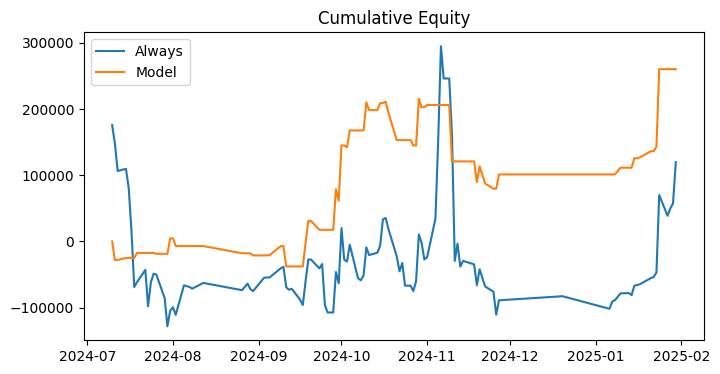

In [32]:
def equity_curve(pnl_series):
    return pnl_series.cumsum()


pnl_series = df.loc[y_test.index, "pnl_next"]
pnl_model_series = df.loc[y_test.index, "pnl_next"].where(signals == 0, 0)

plt.figure()
plt.plot(equity_curve(pnl_series), label="Always")
plt.plot(equity_curve(pnl_model_series), label="Model")
plt.title("Cumulative Equity")
plt.legend()
plt.show()

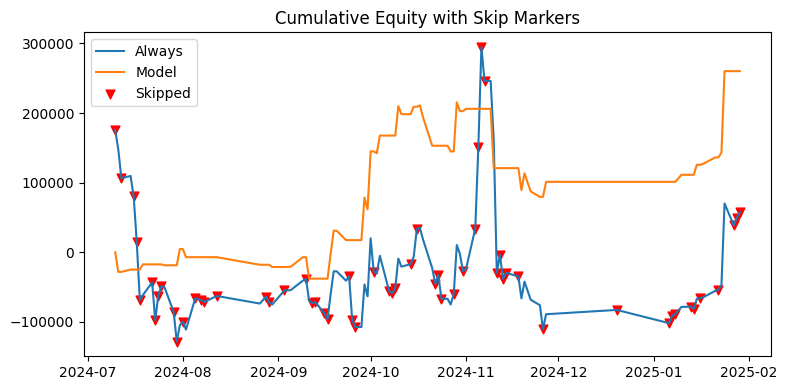

In [33]:
def equity_curve(p):
    return p.cumsum()


jj = 0
hh = -1

eq_always = equity_curve(pnl_series)[jj:hh]
eq_model = equity_curve(pnl_model_series)[jj:hh]

bad_mask = signals[jj:hh] == 1  # model skipped
bad_idx = y_test[jj:hh].index[bad_mask]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(eq_always, label="Always")
ax.plot(eq_model, label="Model")

# mark skip days on always-trade curvea
ax.scatter(
    bad_idx, eq_always.loc[bad_idx], marker="v", color="red", s=40, label="Skipped"
)

ax.set_title("Cumulative Equity with Skip Markers")
ax.legend()
plt.tight_layout()
plt.show()

In [34]:
booster = lgbm.booster_  # unwrap sklearn wrapper

gain = booster.feature_importance(importance_type="gain")
names = booster.feature_name()

import pandas as pd

imp = pd.DataFrame({"feature": names, "gain": gain}).sort_values(
    "gain", ascending=False
)
imp.head(20)

,feature,gain
10,td_5d_std,726.092864
12,dow,628.555918
9,td_3d_mean,443.702517
11,fee_impact,404.591732
6,total_delta,358.833563
1,orders,343.730533
4,net,321.074516
3,qty,286.319528
5,unrealized_delta,283.722453
13,month,275.985951


In [35]:
gain = booster.feature_importance(importance_type="gain")
names = booster.feature_name()
imp = {n: g for n, g in zip(names, gain)}

total = sum(gain)
pct = {n: g / total for n, g in imp.items()}

display(pct)

{'symbols': np.float64(0.05482841646890881),
 'orders': np.float64(0.0709931911008266),
 'fills': np.float64(0.04976793382459168),
 'qty': np.float64(0.05913567465224321),
 'net': np.float64(0.06631387769907363),
 'unrealized_delta': np.float64(0.05859928165061989),
 'total_delta': np.float64(0.07411253095616964),
 'gross': np.float64(0.01406145497615166),
 'fee_sum': np.float64(0.03545599786561378),
 'td_3d_mean': np.float64(0.09164113915209401),
 'td_5d_std': np.float64(0.14996529132836817),
 'fee_impact': np.float64(0.08356330161715816),
 'dow': np.float64(0.12982026967027727),
 'month': np.float64(0.0570014051065593),
 'quarter': np.float64(0.004740233931344211)}